# Регресійні моделі.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
pd.set_option('display.precision',3)

## Підготовка даних для тренування.

In [45]:
cl_data = pd.read_csv('data/clean_data.csv')

In [46]:
cl_data.head()

,sq_mt_built,floor,buy_price,house_type_id,is_renewal_needed,built_year,has_ac,has_fitted_wardrobes,has_garden,has_terrace,has_balcony,has_storage_room,has_green_zones,has_parking,distr_coef
0,64.0,3.0,85000,1,0,1960.0,1,0,0,0,0,0,0,0,0.153
1,70.0,4.0,129900,1,1,1970.0,0,1,0,1,0,0,0,0,0.189
2,94.0,1.0,144247,1,0,1970.0,0,1,0,0,0,1,0,0,0.190
3,64.0,0.0,109900,1,0,1955.0,0,0,0,0,0,1,0,0,0.190
4,108.0,4.0,260000,1,0,2003.0,1,1,0,0,0,1,1,1,0.210


In [47]:
y = cl_data.buy_price
X = cl_data.drop('buy_price', axis=1)

In [48]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
# X_test_scaled = ss.transform(X_test)
# y_train = np.array(y_train)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [50]:
def metrics (y_test, y_pred):
    print('Test set metrics:')
    print()
    mae = mean_absolute_error(y_test, y_pred)
    mae_perc = np.mean(abs(y_test - y_pred)*100/y_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    r2 = r2_score(y_test, y_pred)
    
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean absolute error (%): {mae_perc:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    print(f'R2 score for test set: {r2:.4f}')
    print('#'*20)
    print()
    return r2, mae, mae_perc, rmse

In [51]:
def create_result_df(actual, predict):
    df = pd.DataFrame(actual)
    df.rename(columns={df.columns[0]: 'actual'}, inplace=True)
    df.insert(len(df.columns), column='predict', value=predict)
    df.insert(len(df.columns), column='difference', value=df.actual - df.predict)
    df.insert(len(df.columns), column='diff%', value=abs(df.difference)/df.actual *100 )
#     df.insert(len(df.columns), column='squared', value= df.difference**2)
    return df

In [52]:
def show_hist(df, x_zeroline = False):
    plt.figure(figsize=(10, 6))
    sb.histplot(data=df, x=df.actual, bins=50, kde=False, color='blue', alpha=0.7)
    sb.histplot(data=df, x=df.predict, bins=50, kde=False, color='orange', alpha = 0.5)
    if x_zeroline:
        plt.axvline(linewidth=1, color='r', linestyle = '--', x=0, ymin=0, ymax=2500)
        plt.legend(labels=['Zero line','Actual prices','Predicted prices'])
    else:
        plt.legend(labels=['Actual prices','Predicted prices'])
    plt.show ()

In [53]:
def show_scatter(df):
    plt.scatter(df.actual, df.predict, marker='.', alpha=0.6)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    lims=[0, max(df.actual)]
    plt.plot(lims, lims, 'r')
    plt.show()    

## Модель багатофакторної лінійної регресії

In [54]:
lr_model = LinearRegression()

In [55]:
%%timeit -n 1 -r 1
lr_model.fit(X_train, y_train)

6.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [56]:
lr_y_pred = lr_model.predict(X_test)

In [57]:
lr_pred_price = lr_model.predict(X)

In [58]:
lr_df = create_result_df(y, lr_pred_price)
lr_df.head(10)

,actual,predict,difference,diff%
0,85000,16476.329,68523.671,80.616
1,129900,21231.839,108668.161,83.655
2,144247,137203.675,7043.325,4.883
3,109900,45424.557,64475.443,58.667
4,260000,284839.105,-24839.105,9.554
5,195000,293215.642,-98215.642,50.367
6,190000,302856.312,-112856.312,59.398
7,198500,233231.171,-34731.171,17.497
8,212000,161887.596,50112.404,23.638
9,131400,124250.229,7149.771,5.441


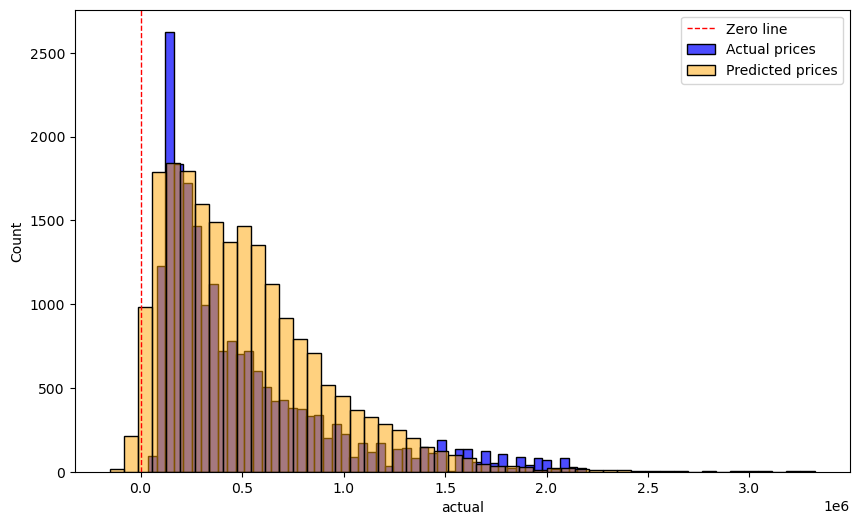

In [59]:
show_hist(lr_df, x_zeroline=True)

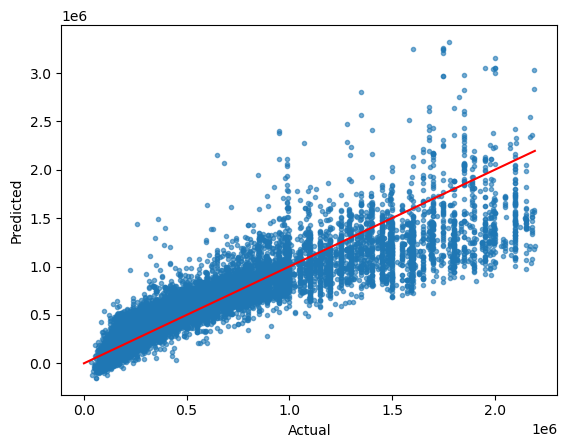

In [60]:
show_scatter(lr_df)

#### Показники моделі Linear Regression:  

In [61]:
lr_r2, lr_mae, lr_mae_perc, lr_rmse = metrics(y_test, lr_y_pred)
lr_train_score = lr_model.score(X_train, y_train)
lr_score = lr_model.score(X, y)
print(f"R2 score for train set {lr_train_score:.4f}")
print(f"R2 score for data set {lr_score:.4f}")

Test set metrics:

Mean absolute error: 116713.81
Mean absolute error (%): 30.24
Root mean squared error: 187432.75
R2 score for test set: 0.8176
####################

R2 score for train set 0.8145
R2 score for data set 0.8152


##  Модель Random Forest

#### Підбір гіперпараметрів

In [62]:
n_estimators = [100, 200, 300]
max_depth = [8, 12, 15]
min_samples_split = [2, 7, 18, 23]
min_samples_leaf = [2, 4, 7, 18]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv = 5, verbose = 1, n_jobs=-1)
gs.fit(X, y)
rf_model = gs.best_estimator_
gs.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 18,
 'n_estimators': 200}

In [63]:
rf_y_pred = rf_model.predict(X_test)

In [64]:
rf_pred_price = rf_model.predict(X)

In [65]:
rf_df = create_result_df(y, rf_pred_price)
rf_df.head(10)

,actual,predict,difference,diff%
0,85000,96139.807,-11139.807,13.106
1,129900,117031.352,12868.648,9.907
2,144247,166440.840,-22193.840,15.386
3,109900,111001.995,-1101.995,1.003
4,260000,274307.592,-14307.592,5.503
5,195000,213486.032,-18486.032,9.480
6,190000,221921.469,-31921.469,16.801
7,198500,185121.503,13378.497,6.740
8,212000,205180.181,6819.819,3.217
9,131400,152973.589,-21573.589,16.418


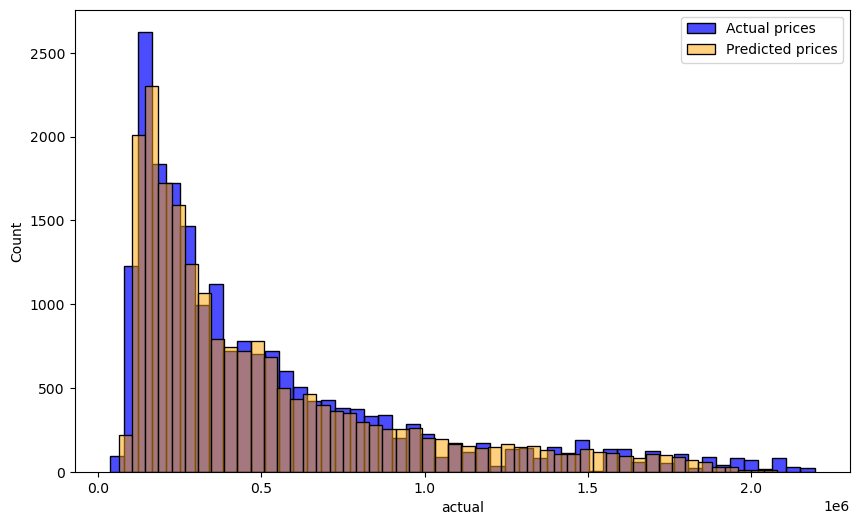

In [66]:
show_hist(rf_df)

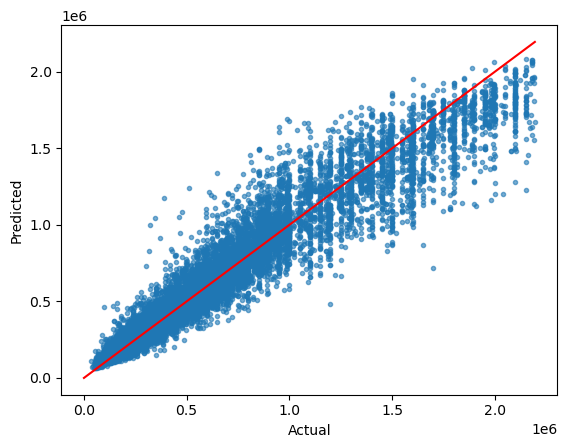

In [67]:
show_scatter(rf_df)

#### Показники моделі Random Forest:

In [68]:
rf_r2, rf_mae, rf_mae_perc, rf_rmse = metrics(y_test, rf_y_pred)
rf_train_score = rf_model.score(X_train, y_train)
rf_score = rf_model.score(X, y)
print(f"R2 score for train set {rf_train_score:.4f}")
print(f"R2 score for data set {rf_score:.4f}")

Test set metrics:

Mean absolute error: 63932.32
Mean absolute error (%): 13.85
Root mean squared error: 108818.39
R2 score for test set: 0.9385
####################

R2 score for train set 0.9369
R2 score for data set 0.9372


## Модель CatBoostRegressor

In [69]:
cb_model = CatBoostRegressor()

In [70]:
%%timeit -n 1 -r 1
cb_model.fit(X_train,y_train, verbose=False)

2.53 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:
cb_y_pred = cb_model.predict(X_test)

In [72]:
cb_pred_price = cb_model.predict(X)

In [73]:
cb_df = create_result_df(y, cb_pred_price)
cb_df.head(10)

,actual,predict,difference,diff%
0,85000,95218.012,-10218.012,12.021
1,129900,111726.110,18173.890,13.991
2,144247,176084.252,-31837.252,22.071
3,109900,102271.447,7628.553,6.941
4,260000,274420.147,-14420.147,5.546
5,195000,200017.869,-5017.869,2.573
6,190000,255985.197,-65985.197,34.729
7,198500,181238.699,17261.301,8.696
8,212000,212275.298,-275.298,0.130
9,131400,168319.720,-36919.720,28.097


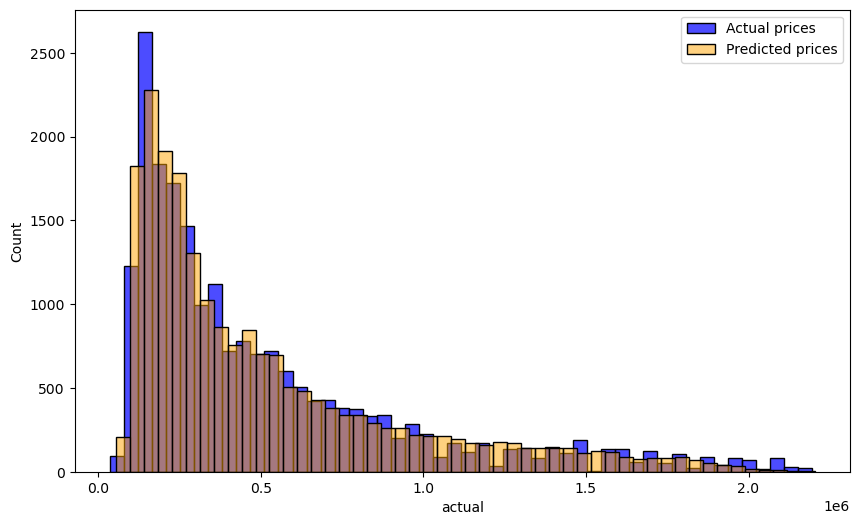

In [74]:
show_hist(cb_df)

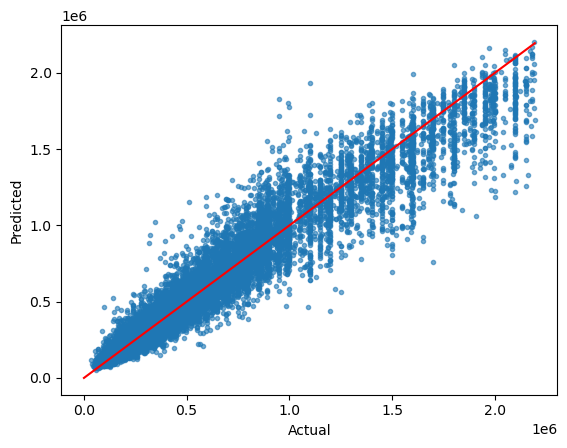

In [75]:
show_scatter(cb_df)

#### Показники моделі CatBoost:

In [76]:
cb_r2, cb_mae, cb_mae_perc, cb_rmse = metrics(y_test, cb_y_pred)
cb_train_score = cb_model.score(X_train, y_train)
cb_score = cb_model.score(X, y)
print(f"R2 score for train set {cb_train_score:.4f}")
print(f"R2 score for data set {cb_score:.4f}")

Test set metrics:

Mean absolute error: 76653.44
Mean absolute error (%): 16.35
Root mean squared error: 130563.76
R2 score for test set: 0.9115
####################

R2 score for train set 0.9408
R2 score for data set 0.9350


Модель CatBoost демонструє непогані результати. В порівнянні з Random Forest метрики дещо гірщі, проте модель легковажна і доволі швидко тренується.

## Модель LGBMRegressor

#### Підбір гіперпараметрів

In [77]:
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

grid = GridSearchCV(LGBMRegressor(random_state=0), params, scoring='r2', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

lgbm_model = grid.best_estimator_
grid.best_params_

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 31}

In [78]:
lgbm_y_pred = lgbm_model.predict(X_test)

In [79]:
lgbm_pred_price = lgbm_model.predict(X)

In [80]:
lgbm_df = create_result_df(y, lgbm_pred_price)
lgbm_df.head(10)

,actual,predict,difference,diff%
0,85000,102681.992,-17681.992,20.802
1,129900,108686.057,21213.943,16.331
2,144247,171931.599,-27684.599,19.192
3,109900,116869.873,-6969.873,6.342
4,260000,273033.678,-13033.678,5.013
5,195000,194579.142,420.858,0.216
6,190000,229955.678,-39955.678,21.029
7,198500,187552.109,10947.891,5.515
8,212000,195985.178,16014.822,7.554
9,131400,156202.815,-24802.815,18.876


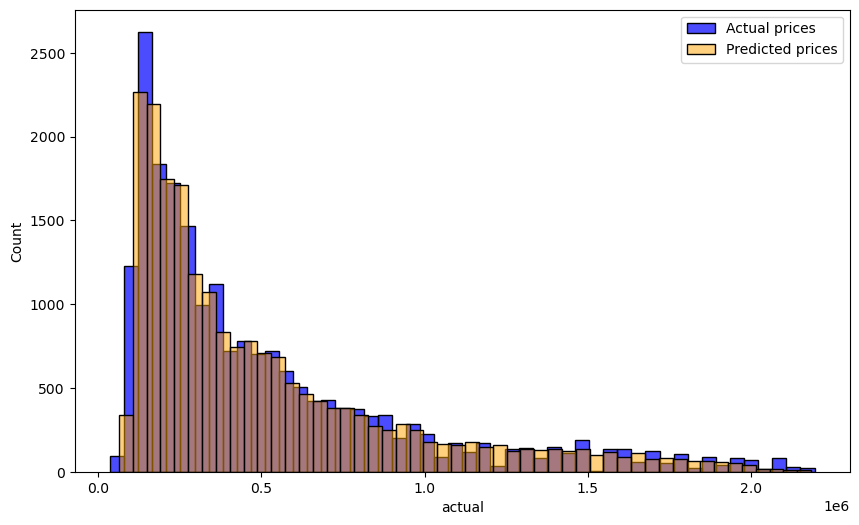

In [81]:
show_hist(lgbm_df)

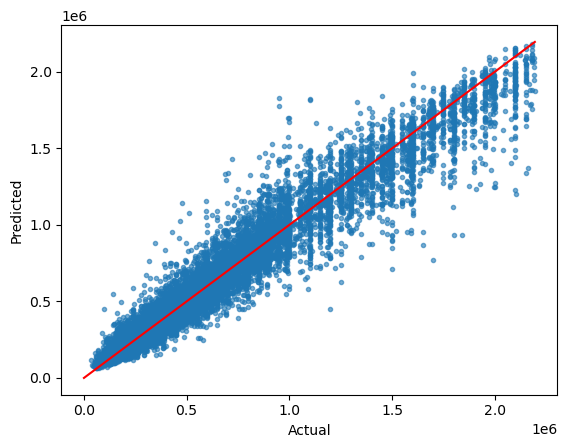

In [82]:
show_scatter(lgbm_df)

#### Показники моделі LGBMRegressor

In [83]:
lgbm_r2, lgbm_mae, lgbm_mae_perc, lgbm_rmse = metrics(y_test, lgbm_y_pred)
lgbm_train_score = lgbm_model.score(X_train, y_train)
lgbm_score = lgbm_model.score(X, y)
print(f"R2 score for train set {lgbm_train_score:.4f}")
print(f"R2 score for data set {lgbm_score:.4f}")

Test set metrics:

Mean absolute error: 74332.76
Mean absolute error (%): 15.75
Root mean squared error: 130486.84
R2 score for test set: 0.9116
####################

R2 score for train set 0.9629
R2 score for data set 0.9529


## Keras NN model

In [84]:
# from tensorflow.keras.models import load_model
# model = load_model('model.h5')
# model.summary()

In [85]:
nn_df = pd.read_csv('data/nn_results.csv')
nn_df.head(10)

,actual,predict,difference,diff%
0,85000,119074.770,-34074.773,40.088
1,129900,127904.700,1995.297,1.536
2,144247,178472.720,-34225.719,23.727
3,109900,118701.914,-8801.914,8.009
4,260000,288167.880,-28167.875,10.834
5,195000,190614.330,4385.672,2.249
6,190000,295635.720,-105635.719,55.598
7,198500,220792.140,-22292.141,11.230
8,212000,206224.270,5775.734,2.724
9,131400,177090.230,-45690.234,34.772


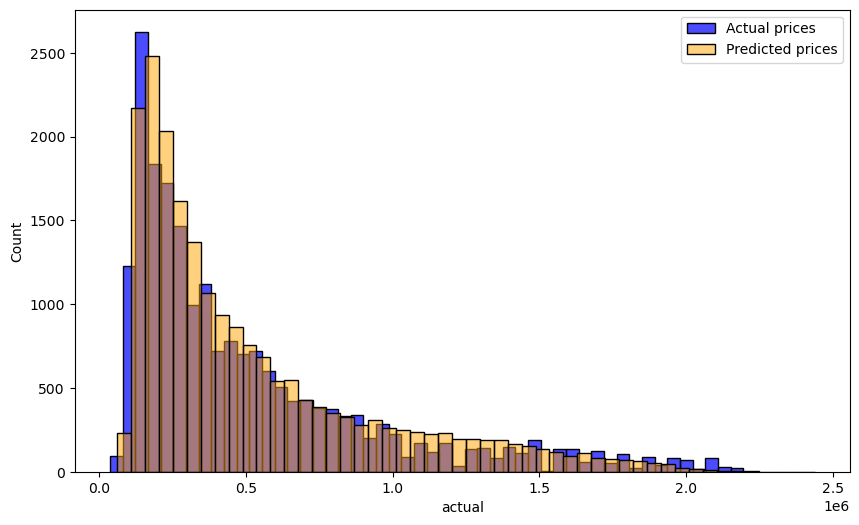

In [86]:
show_hist(nn_df)

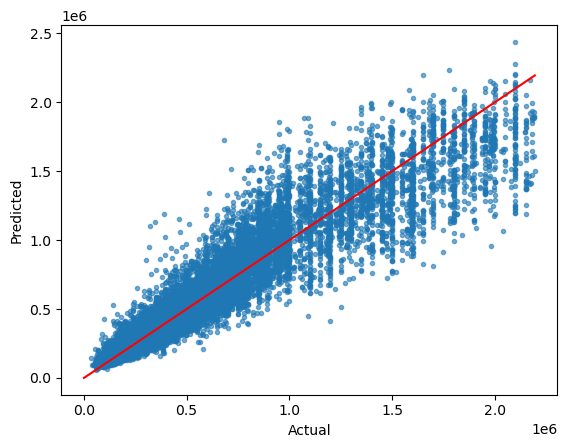

In [87]:
show_scatter(nn_df)

In [88]:
import json
with open('data/nn_metrics.json', 'r') as openfile: 
    metrics_dct = json.load(openfile)   

#### Показники моделі нейронної мережі 

In [89]:
nn_metrics = []
for metric, value in metrics_dct.items():
    nn_metrics.append(value) 
    print(metric,': ',round(value, 2))

R2_test :  0.89
mae :  87240.87
mae% :  19.09
rmse :  144591.02
R2_total :  0.89


### Порівняння моделей.

In [90]:
df_res = pd.DataFrame( {'Linear_Regression' : [lr_r2, lr_mae, lr_mae_perc, lr_rmse],
                      'Random_Forest' : [rf_r2, rf_mae, rf_mae_perc, rf_rmse],
                      'Cat_Boost' : [cb_r2, cb_mae, cb_mae_perc, cb_rmse],
                      'LGBMRegressor': [lgbm_r2, lgbm_mae, lgbm_mae_perc, lgbm_rmse],
                      'NN_Keras': nn_metrics[:4]
                       },
                      index=['Score', 'MAE', 'MAE%', 'RMSE'])

In [91]:
df_res.T

,Score,MAE,MAE%,RMSE
Linear_Regression,0.818,116713.806,30.238,187432.753
Random_Forest,0.939,63932.315,13.846,108818.385
Cat_Boost,0.911,76653.443,16.351,130563.759
LGBMRegressor,0.912,74332.764,15.752,130486.836
NN_Keras,0.891,87240.870,19.094,144591.020


1. Модель на основі Linear Regression взагалі незадовільна, максимальна похибка сягає 400%, на невеликій площі житла модель прогнозує від'ємні значення.  
2. Модель на основі Random Forest є найбільш точною з усіх, але вона найбільш складна і потребує найбільший обсяг обчислювальних потужностей.  
3. Модель Cat Boost демонструє задовільну точність і доволі швидко тренується. Гіперпараметри для моделі не підбиралися.
4. Модель LGBMRegressor вдалось дещо покарщити за рахунок підбіру гіперпараметрів.  
5. Модель на основі нейронної мережі є задовільною, але за точністю і часом тренування вона поступається моделям на основі дерев рішень.

Для всіх моделей точність падає при високих значеннях ціни, це пов'язано зі значним зміщенням данних.
Можливо, для прогнозування цін на елітну нерухомість вартістю від 1,5 млн. потрібна окрема модель.

**Всі моделі на основі дерев дають приблизно однаковий показник точності $R^2 \approx 0,91$, який можна незначно покращити через підпір гіперпарамтрів.  
Найточнішою моделью для цих данних є модель Random Forest. Але вона потребує найбільше часу на тренування і підбір параметрів.**
